In [165]:
from collections import defaultdict

import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows, n_cols, n_win, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [123]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
#     cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))
    
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

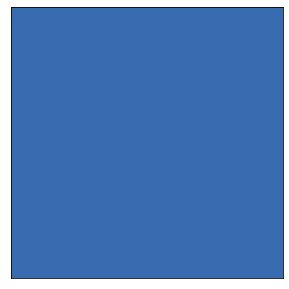

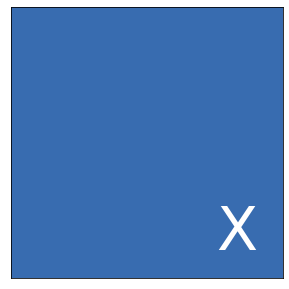

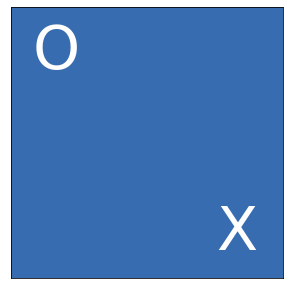

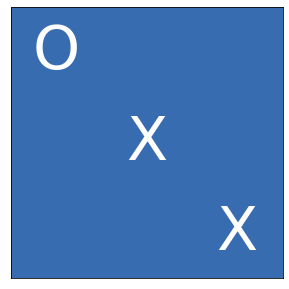

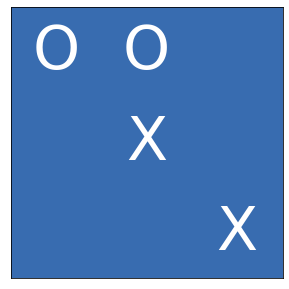

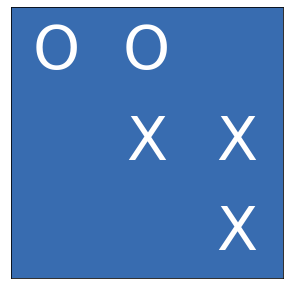

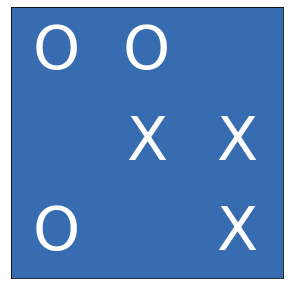

Крестики выиграли!


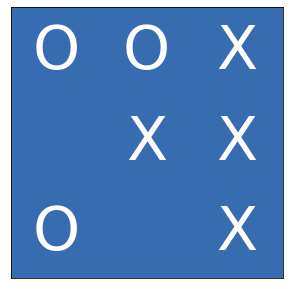

In [124]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
np.random.seed(100)
plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=60)

# Часть первая: крестики-нолики при помощи Q-обучения
В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.
1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

In [159]:
class TicTacQLearning:
    def __init__(self, env, alpha, eps, gamma):
        self.env = env
        self.alpha = alpha
        self.eps = eps
        self.gamma = gamma
        self.q = defaultdict(lambda: np.zeros((self.env.n_rows, self.env.n_cols)))
    
    def _get_action(self, state, empty_idx, mode):
        if mode == "train":
            if np.random.rand() > self.eps:
                return self._get_action(state, empty_idx, mode="best")
            else:
                return self._get_action(state, empty_idx, mode="random")
        
        elif mode == "best":
            if self.q.get(state) is not None:
                max_p_idx = np.argmax(self.q[state][tuple(empty_idx.T)])
                return empty_idx[max_p_idx]
            else:
                return self._get_action(state, empty_idx, mode="random")
        
        elif mode == "random":
            return empty_idx[np.random.randint(empty_idx.shape[0])]
        
        else:
            raise ValueError(f"Mode {mode} not allowed")
        
    def train_episode(self, on_policy = True):
        env.reset()
        state = env.getHash()
        action = self._get_action(state, self.env.getEmptySpaces(), mode="train")
        done = False  
        while not done:
            (next_state, empty_idx, next_turn), reward, done, _ = env.step(action)
            # invert reward for naughts
            reward *= -next_turn
            if not done:
                next_action = self._get_action(next_state, empty_idx, mode="train")
                # invert discount for next_state Q
                next_state_q = - self.q[next_state][next_action] if on_policy else - np.max(self.q[next_state])
            else:
                next_state_q = 0.0
            self.q[state][action] += self.alpha * (reward + self.gamma * next_state_q - self.q[state][action])
            state, action = next_state, next_action
    
    def test_episode(self, crosses_mode, naughts_mode):
        env.reset()
        state = env.getHash()
        empty_idx = self.env.getEmptySpaces()
        done = False
        while not done:
            action = self._get_action(state, empty_idx, mode=crosses_mode if env.curTurn == 1 else naughts_mode)
            (state, empty_idx, _), reward, done, _ = env.step(action)
        return reward


In [197]:
RESULT_LIST = ["crosses_win", "crosses_draw", "naughts_win", "naughts_draw", "best_win", "best_draw"]

In [200]:
def test_actor(actor, n_test, test_list):
    n_results = defaultdict(float)
    for _ in range(n_test):
        if "crosses" in test_list:
            crosses_reward = actor.test_episode(crosses_mode="best", naughts_mode="random")
            if crosses_reward == 1:
                n_results["crosses_win"] +=1 
            elif crosses_reward == 0:
                n_results["crosses_draw"] +=1
        if "naughts" in test_list:
            naughts_reward = actor.test_episode(crosses_mode="random", naughts_mode="best")
            if naughts_reward == -1:
                n_results["naughts_win"] +=1 
            elif naughts_reward == 0:
                n_results["naughts_draw"] +=1 
                
        if "best" in test_list:
            best_reward = actor.test_episode(crosses_mode="best", naughts_mode="best")
            if best_reward == 1:
                n_results["best_win"] +=1 
            elif best_reward == 0:
                n_results["best_draw"] +=1 
            
    return {k: n_results[k] / n_test for k in RESULT_LIST}

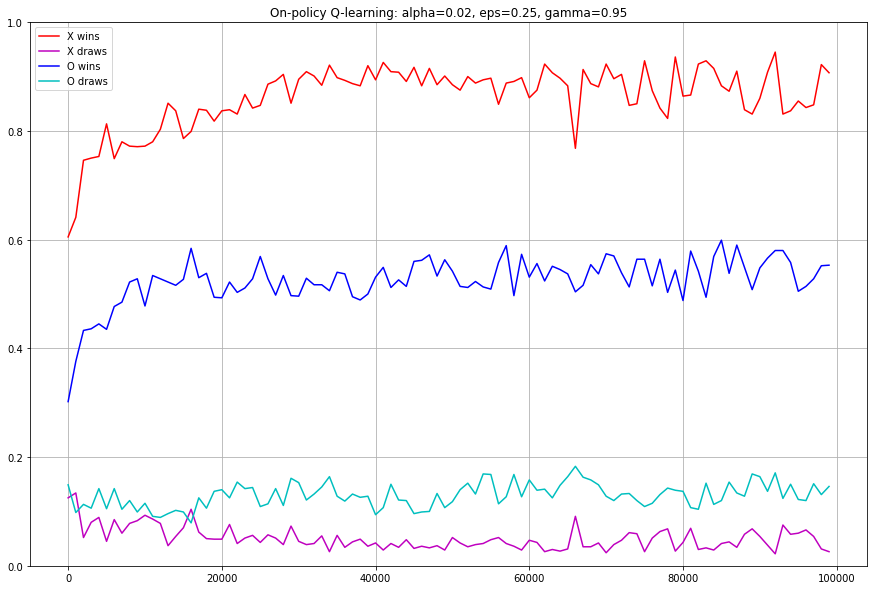

In [191]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)

N_EPISODES = 100_000
N_TEST = 1_000

ALPHA = 0.02 # 0.05
EPS = 0.25 
GAMMA = 0.95 

actor = TicTacQLearning(env=env, alpha=ALPHA, eps=EPS, gamma=GAMMA)

result = defaultdict(list)
ts = []

for i in range(N_EPISODES):
    
    actor.train_episode(on_policy=True)
    
    if (i % N_TEST == 0):
        
        test = test_actor(actor, N_TEST, test_list=["crosses", "naughts"])
        
        _ = [result[name].append(test[name]) for name in RESULT_LIST]
        ts.append(i)
        
        clear_output(True)
        plt.figure(figsize = (15, 10))
        plt.grid()
        plt.plot(ts, result["crosses_win"], "r", label="X wins")
        plt.plot(ts, result["crosses_draw"], "m", label="X draws")
        plt.plot(ts, result["naughts_win"], "b", label="O wins")
        plt.plot(ts, result["naughts_draw"], "c", label="O draws")
        plt.title(f"On-policy Q-learning: alpha={ALPHA}, eps={EPS}, gamma={GAMMA}")
        plt.legend()
        plt.ylim([0, 1])
        plt.show()

env.close()

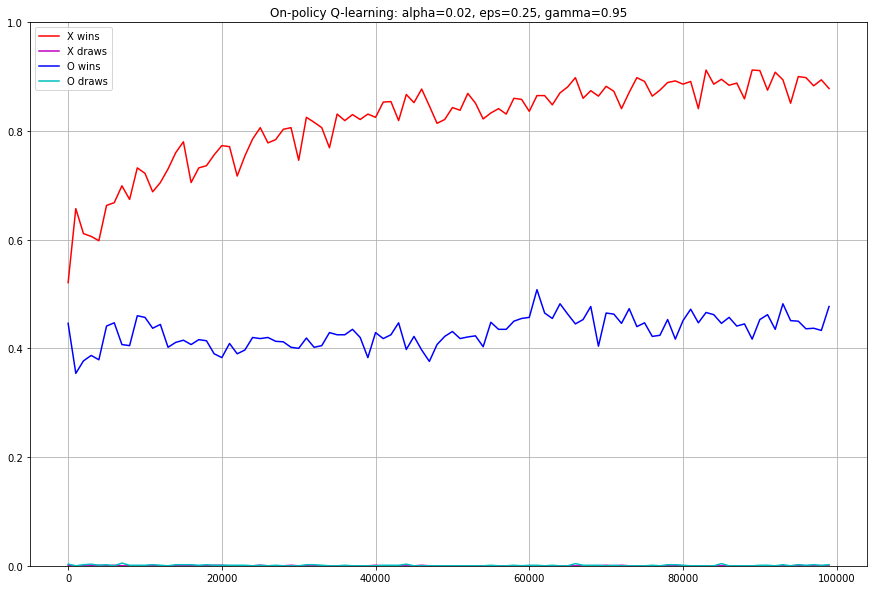

In [202]:
N_ROWS, N_COLS, N_WIN = 4, 4, 3
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)

N_EPISODES = 100_000
N_TEST = 1_000

ALPHA = 0.02 # 0.05
EPS = 0.25 
GAMMA = 0.95 

actor = TicTacQLearning(env=env, alpha=ALPHA, eps=EPS, gamma=GAMMA)

result = defaultdict(list)
ts = []

for i in range(N_EPISODES):
    
    actor.train_episode(on_policy=True)
    
    if (i % N_TEST == 0):
        
        test = test_actor(actor, N_TEST, test_list=["crosses", "naughts"])
        
        _ = [result[name].append(test[name]) for name in RESULT_LIST]
        ts.append(i)
        
        clear_output(True)
        plt.figure(figsize = (15, 10))
        plt.grid()
        plt.plot(ts, result["crosses_win"], "r", label="X wins")
        plt.plot(ts, result["crosses_draw"], "m", label="X draws")
        plt.plot(ts, result["naughts_win"], "b", label="O wins")
        plt.plot(ts, result["naughts_draw"], "c", label="O draws")
        plt.title(f"On-policy Q-learning: alpha={ALPHA}, eps={EPS}, gamma={GAMMA}")
        plt.legend()
        plt.ylim([0, 1])
        plt.show()

env.close()

* Для поля 4Х4 обучение происходит медленнее, что объяснимо - размерность пространства действий больше в 1.77 раза

# Часть вторая: добавим нейронных сетей
Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.
4. Реализуйте Double DQN и/или Dueling DQN.

# Часть третья: расширим и углубим поиск
Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.

5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).
6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.
